# QueueSim Quick Start

Minimal examples using `queuesim.py`.

#### Run this notebook in Juypter with the `conda qmcpy` environment or [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/MATH565Fall2025/blob/main/notebooks/quesim_quick_start.ipynb?flush_cache=true)

In [1]:
import sys, time
import numpy as np, scipy as sp, matplotlib.pyplot as plt
import qmcpy as qp
from pathlib import Path
from IPython.display import display, Markdown
REPO_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(REPO_ROOT))
from classlib.queuesim import BaseCfg, A_Config, B_Config, SingleServerEU1, DriveThruBlocking, step_plot
import classlib.nbviz as nb
nb.init(use_tex=True)     # styling, Tol cycle, CSS
colors, TINY = nb.TOL_BRIGHT, nb.TINY


## Model A: Single-server E/U/1
This is a model of a line at a Starbucks where there is an exponential waiting time for customers to arrive and a uniform service time.  It is a **single-server queue** with  
- **Exponential interarrival times** (mean rate λ)  
- **Uniform service times** on \[a, b\]

This corresponds to an **E/U/1** (or M/U/1) queue.

| Symbol | Notebook name | Meaning | Typical values / notes |
|:--:|:--|:--|:--|
| λ | `lambda_` | Mean **arrival rate** (customers per time unit) | Try 0.5–1.2 |
| a,b | `service_a`, `service_b` | Endpoints of the **Uniform service-time distribution** | Mean service = (a + b)/2 |
| ρ | ρ = λ × E\[S\] | **Server utilization** (fraction of time busy) | Must be < 1 for stability |
| record_state_trajectory | `record_state_trajectory` | Whether to record N(t) for plotting | Set `True` to plot; `False` to speed up |

**Typical starting point**

```python
λ = 0.8
a, b = 0.8, 1.2
E_S = (a + b) / 2 = 1.0
ρ = λ * E_S = 0.8
````


The simulator can stop in two different ways:

| Option | Config field | Meaning |
|:--|:--|:--|
| **By time** | `t_end` | Stop when the simulation clock reaches this value |
| **By number served** | `n_complete` | Stop when this many customers have *departed* the system |

You may specify one or both.  
If both are given, the run stops when **either condition is met** (whichever comes first).

**Examples**

```python
# Stop after 2000 departures (ignore time)
cfgA = A_Config(n_complete=2000, t_end=None, ...)

# Stop at time 5000 or after 2000 departures, whichever comes first
cfgA = A_Config(t_end=5000, n_complete=2000, ...)
````

In [2]:
cfgA = A_Config(t_end=2000.0, lambda_=0.3, service_a=.8, service_b=1.2, record_state_trajectory=True)
simA = SingleServerEU1(cfgA)
simA.run()
simA.summary()

{'sim_time': 2000.0,
 'arrivals': 621,
 'departures': 620,
 'lambda_hat': 0.3105,
 'avg_L': 0.37667354185662627,
 'avg_Wq': 0.21397881672112853,
 'avg_W': 1.215075941472988,
 'L_via_Little': 0.37728107982736275,
 'util_est': 0.31091906205368913,
 'mean_service': 1.002964716302223}

After running `simA.summary()`, you’ll see a dictionary of key performance metrics:

| Field | Meaning | Interpretation |
|:--|:--|:--|
| `sim_time` | Total simulated time | Either the clock time `t_end` or the time when `n_complete` customers finished |
| `arrivals` | Number of customers who entered the system | Total arrivals simulated |
| `departures` | Number of customers who completed service | Should match `n_complete` if you stopped by completions |
| `lambda_hat` | Observed **arrival rate** = arrivals ÷ sim_time | Empirical estimate of λ; should be close to the input `lambda_` |
| `avg_L` | Time-average number of customers **in the system** | Includes those waiting and being served |
| `avg_Wq` | Mean **waiting time in queue** (before service) | Average over all completed customers |
| `avg_W` | Mean **total time in system** = waiting + service | Average “sojourn time” per customer |
| `L_via_Little` | \( \hat{\lambda} \times \text{avg\_W} \) | Check of **Little’s Law**: should roughly equal `avg_L` |
| `util_est` | Fraction of time the server was busy | Empirical **utilization**, ≈ ρ = λ E[S] |
| `mean_service` | Average service time actually observed | Should be close to (a + b)/2 |

Use `avg_L ≈ λ × avg_W` to verify Little’s Law empirically and to see how results change as utilization ρ approaches 1.

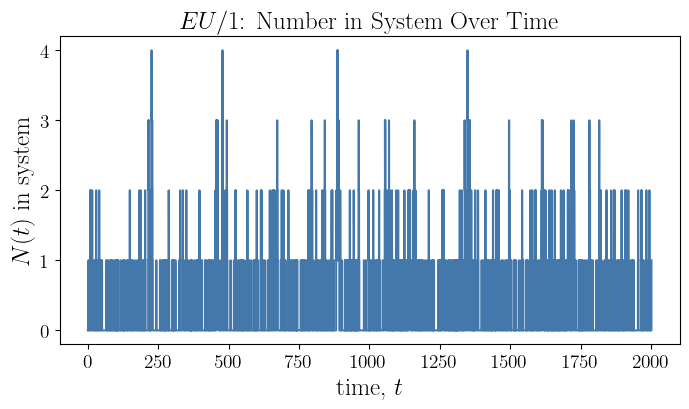

In [3]:
step_plot(simA, r"$EU/1$: Number in System Over Time")

## Model B: Drive-thru with downstream blocking

This model represents a **two-stage tandem queue**, like at a McDonald's:
1. **Stage 1 – Order Window**: customers place orders.
2. **Stage 2 – Pickup Window**: customers receive orders.
   
If the pickup lane is full, Stage 1 becomes **blocked** and cannot release new cars.

| Symbol / Field | Meaning | Notes |
|:--|:--|:--|
| λ | `lambda_` | Mean **arrival rate** (cars per time unit) |
| a₁,b₁ | `s1_a`, `s1_b` | Uniform \[a₁,b₁\] **service time** at the order window |
| a₂,b₂ | `s2_a`, `s2_b` | Uniform \[a₂,b₂\] **service time** at the pickup window |
| `K2_total` | Total capacity at pickup (queue + window) | Finite buffer; if full → blocking |
| `t_end` / `n_complete` | Stopping criteria | Same rules as Model A |
| `record_state_trajectory` | Whether to record N(t) for plotting | Set True to view the system trajectory |

**Interpretation**

- When `K2_total` is small, blocking occurs frequently — Stage 1 idles even though customers are waiting.  
- Larger `K2_total` reduces blocking, approaching the behavior of an open tandem queue.

In [4]:
cfgB = B_Config(t_end=1500.0, lambda_=0.9, s1_a=0.7, s1_b=1.1, s2_a=0.5, s2_b=1.0, K2_total=6, record_state_trajectory=True)
simB = DriveThruBlocking(cfgB)
simB.run()
simB.summary()

{'sim_time': 1500.0,
 'arrivals': 1394,
 'departures': 1392,
 'avg_N': 3.4667959217411983,
 'avg_s1_wait': 2.0558798264667013,
 'avg_s2_wait': 0.03135258724335417,
 'avg_total_time': 3.735336536622078,
 's1_util_est': 0.8355780597611594,
 's2_util_est': 0.694368961906607,
 'blocking_fraction_time': 0.0,
 'K2_total': 6,
 'lambda_param': 0.9}

The dictionary returned by `simB.summary()` contains the following fields:

| Field | Meaning | Interpretation |
|:--|:--|:--|
| `sim_time` | Total simulated time | Duration of the run |
| `arrivals` / `departures` | Cars that entered / completed service | Usually match if the run ends cleanly |
| `avg_N` | Average total number of cars in the system | Includes both queues and windows |
| `avg_s1_wait` | Mean waiting time before ordering | Queueing delay at the order window |
| `avg_s2_wait` | Mean waiting time before pickup | Delay in the pickup lane |
| `avg_total_time` | Mean time from arrival to departure | Total “drive-thru time” |
| `s1_util_est`, `s2_util_est` | Estimated utilization of each window | Fraction of time each is busy |
| `blocking_fraction_time` | Fraction of simulation time Stage 1 was blocked | Measures **downstream congestion** |
| `K2_total` | Pickup-lane capacity used | From configuration |
| `lambda_param` | Input arrival rate | For reference |

**Interpretation**

- If `blocking_fraction_time` ≈ 0 → pickup lane rarely full → smooth flow.  
- If it’s large (e.g., > 0.3) → bottleneck at pickup causes Stage 1 idle periods.  
- Compare `s1_util_est` and `s2_util_est` to see which stage limits throughput.  
- Use `avg_total_time` to study how queueing delays grow as you vary λ or `K2_total`.

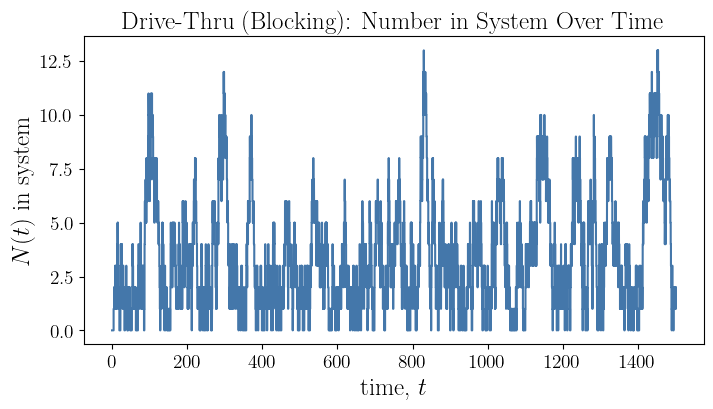

In [5]:
step_plot(simB, "Drive-Thru (Blocking): Number in System Over Time")